# Installing and importing

In [ ]:
!wget -O friends.csv https://cups.mail.ru/api_v2/task/1100/100
!wget -O train.csv https://cups.mail.ru/api_v2/task/1100/101
!wget -O trainEducationalFeatures.csv https://cups.mail.ru/api_v2/task/1100/102
!wget -O trainGroups.csv https://cups.mail.ru/api_v2/task/1100/103

In [ ]:
!pip install catboost

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor

# NN
import keras

# other
from typing import List, Tuple
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Score function

In [7]:
def score(y_test, y_pred):
    return 1 / (mean_squared_error(y_test, y_pred) ** 0.5)

# Data reading

In [8]:
friends = pd.read_csv("friends.csv")
train = pd.read_csv("train.csv")
trainEducationFeatures = pd.read_csv("trainEducationFeatures.csv")
trainGroups = pd.read_csv("trainGroups.csv")

# Small EDA

In [9]:
friends.head()

,uid,fuid
0,105728,104361
1,2026,38044
2,107090,6391
3,88157,6391
4,49843,6391


In [10]:
friends.shape

(4109877, 2)

In [11]:
friends.isna().sum()

uid     0
fuid    0
dtype: int64

In [12]:
f = {}
for i in friends.index:
    uid, fuid = friends.at[i, "uid"], friends.at[i, "fuid"]
    f[uid] = f.setdefault(uid, 0) + 1
    f[fuid] = f.setdefault(fuid, 0) + 1
fv = list(f.values())

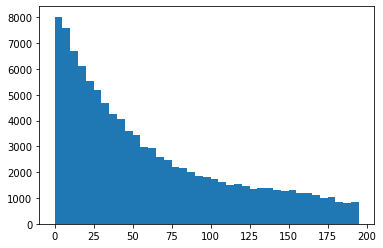

In [33]:
plt.hist(fv, bins=list(range(0, 200, 5)))
plt.show()

Main amount of friends count is between 0 and 50

In [14]:
train.head()

,uid,age,registered_year
0,85788,32,2020
1,19171,30,2009
2,7780,51,2012
3,14998,17,2019
4,94913,33,2010


In [15]:
train.shape

(29469, 3)

In [16]:
train.isna().sum()

uid                0
age                0
registered_year    0
dtype: int64

In [17]:
trainEducationFeatures.head()

,uid,school_education,graduation_1,graduation_2,graduation_3,graduation_4,graduation_5,graduation_6,graduation_7
0,356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26356,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,NaN
2,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30288,2008.0,NaN,NaN,NaN,NaN,2013.0,NaN,NaN


In [18]:
trainEducationFeatures.shape

(29469, 9)

In [19]:
trainEducationFeatures.isna().sum()

uid                     0
school_education    20355
graduation_1        29418
graduation_2        28867
graduation_3        29149
graduation_4        29417
graduation_5        27683
graduation_6        29118
graduation_7        29299
dtype: int64

In [20]:
trainGroups.head()

,uid,gid
0,34673,110624
1,119303,108687
2,89035,234084
3,7322,351543
4,102327,304142


In [21]:
trainGroups.shape

(1086091, 2)

In [22]:
trainGroups.isna().sum()

uid    0
gid    0
dtype: int64

In [23]:
gu = {}
ug = {}
for i in trainGroups.index:
    uid, gid = trainGroups.at[i, "uid"], trainGroups.at[i, "gid"]
    ug[uid] = ug.setdefault(uid, 0) + 1
    gu[gid] = gu.setdefault(gid, 0) + 1
guv = list(gu.values())
ugv = list(ug.values())

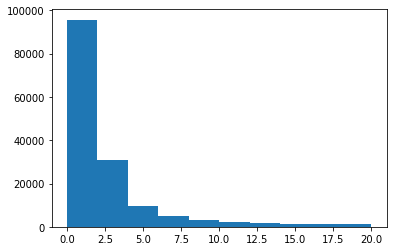

In [29]:
plt.hist(guv, bins=list(range(0, 22, 2)))
plt.show()

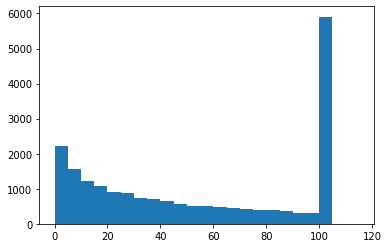

In [32]:
plt.hist(ugv, bins=list(range(0, 120, 5)))
plt.show()

A lot of users have ~100 groups, yet a lot of groups have ~2 users

# Feature engineering

Lets calculate friends count

In [34]:
def count_friends(friends) -> dict:
    count_friends = {}
    for index in friends.index:
        uid, fuid = friends.at[index, "uid"], friends.at[index, "fuid"]
        count_friends[uid] = count_friends.setdefault(uid, 0) + 1
        count_friends[fuid] = count_friends.setdefault(fuid, 0) + 1
    return count_friends

In [35]:
cfriends = count_friends(friends)

In [87]:
def get_count_friends(uids, cfriends) -> List[int]:
    res = [0] * len(uids)
    for i, uid in enumerate(uids):
        res[i] = cfriends.setdefault(uid, 0)
    return res

In [84]:
train["cfriends"] = get_count_friends(train.uid, cfriends)

In [85]:
train.head()

,uid,age,registered_year,cfriends,prob_age,grads_count,groups_count,mean_group_age,median_group_age
0,85788,32,2020,33,0.0,0,4,36.746115,37.847786
1,19171,30,2009,126,0.0,0,100,34.821975,34.390129
2,7780,51,2012,26,0.0,0,0,0.000000,0.000000
3,14998,17,2019,1,19.0,1,0,0.000000,0.000000
4,94913,33,2010,19,35.0,1,0,0.000000,0.000000


Let's collect friends graph and save it (or load)

In [38]:
def collect_friends(friends) -> dict:
    uid_friends = {}
    for index in friends.index:
        uid, fuid = friends.at[index, "uid"], friends.at[index, "fuid"]
        uid_friends[uid] = uid_friends.setdefault(uid, []) + [fuid]
        uid_friends[fuid] = uid_friends.setdefault(fuid, []) + [uid]
    return uid_friends

In [ ]:
# with open("uid_friends.pkl", "rb") as fin:
#     uid_friends = pickle.load(fin)

In [39]:
uid_friends = collect_friends(friends)

In [ ]:
with open("uid_friends.pkl", "wb") as fout:
    pickle.dump(uid_friends, fout)

Let's calculate probable age. 

If person ended school in X year, then he is probably (2021 + 17 - X) years old

If person ended university in X year, then he is probably (2021 + 22 - X) years old

Also we will calculate graduates count

In [153]:
def calculate_probable_age(usersEducationFeatures):
    prob_age = {}
    grads_count = {}
    age_diff1 = 17  # age difference for school
    age_diff2 = 22  # age difference for university
    for index in usersEducationFeatures.index:
        count = 0
        skip = False

        if not pd.isnull(usersEducationFeatures.at[index, "school_education"]):
            prob_age[usersEducationFeatures.at[index, "uid"]] = 2021 + age_diff1 - usersEducationFeatures.at[
                index, "school_education"]
            skip = True
        for i in range(1, 8):
            if skip:
                break
            if not pd.isnull(usersEducationFeatures.at[index, f"graduation_{i}"]):
                prob_age[usersEducationFeatures.at[index, "uid"]] = 2021 + age_diff2 - usersEducationFeatures.at[
                    index, f"graduation_{i}"]
                skip = True

        if not pd.isnull(usersEducationFeatures.at[index, "school_education"]):
            count += 1
        for i in range(1, 8):
            if not pd.isnull(usersEducationFeatures.at[index, f"graduation_{i}"]):
                count += 1

        grads_count[usersEducationFeatures.at[index, "uid"]] = count
    return prob_age, grads_count

In [154]:
prob_age, grads_count = calculate_probable_age(trainEducationFeatures)

In [155]:
def get_prob_age(uids, prob_age) -> List[int]:
    res = [0] * len(uids)
    for i, uid in enumerate(uids):
        res[i] = prob_age.setdefault(uid, 0)
    return res

In [156]:
def get_grads_count(uids, grads_count) -> List[int]:
    res = [0] * len(uids)
    for i, uid in enumerate(uids):
        res[i] = grads_count.setdefault(uid, 0)
    return res

In [157]:
train["prob_age"] = get_prob_age(train.uid, prob_age)

In [158]:
train["grads_count"] = get_grads_count(train.uid, grads_count)

In [159]:
train.head()

,uid,age,registered_year,cfriends,prob_age,grads_count,groups_count,mean_group_age,median_group_age,mean_friends_age,median_friends_age,mean_friends2_age,is_prob_age,is_group_age,is_friends_age
0,85788,32,2020,33,0.0,0,4,36.746115,37.847786,36.428571,35.5,35.492795,False,True,True
1,19171,30,2009,126,0.0,0,100,34.821975,34.390129,34.068966,33.0,0.000000,False,True,True
2,7780,51,2012,26,0.0,0,0,0.000000,0.000000,35.000000,32.0,36.676585,False,False,True
3,14998,17,2019,1,19.0,1,0,0.000000,0.000000,0.000000,0.0,16.818182,True,False,False
4,94913,33,2010,19,35.0,1,0,0.000000,0.000000,35.000000,34.0,34.360236,True,False,True


Now let's calculate users groups count

In [69]:
def get_groups_count(uids, usersGroups):
    tmp = usersGroups.groupby("uid").count()
    groups_count = [0] * len(uids)
    for i, uid in enumerate(uids):
        try:
            groups_count[i] = tmp.at[uid, "gid"]
        except:
            continue
    return groups_count

In [70]:
train["groups_count"] = get_groups_count(train.uid, trainGroups)

In [71]:
train.head()

,uid,age,registered_year,cfriends,prob_age,grads_count,groups_count,mean_group_age,median_group_age
0,85788,32,2020,33,0,0,4,36.746115,37.847786
1,19171,30,2009,126,0,0,100,34.821975,34.390129
2,7780,51,2012,26,0,0,0,0.000000,0.000000
3,14998,17,2019,1,19,1,0,0.000000,0.000000
4,94913,33,2010,19,35,1,0,0.000000,0.000000


For next features we need dictionary uid to age and gid to age

In [ ]:
# with open("uid2age.pkl", "rb") as fin:
#     uid2age = pickle.load(fin)

In [53]:
uid2age = {}
for index in train.index:
    uid2age[train.at[index, "uid"]] = train.at[index, "age"]

In [ ]:
with open("uid2age.pkl", "wb") as fout:
    pickle.dump(uid2age, fout)

In [55]:
trainGroups["age"] = 0
uid_groups = {} # dict is mapping uid to his groups ids list
for index in trainGroups.index:
    uid = trainGroups.at[index, "uid"]
    uid_groups[uid] = uid_groups.setdefault(uid, []) + [trainGroups.at[index, "gid"]]
    age = uid2age[uid]
    trainGroups.at[index,"age"] = age

In [ ]:
# with open("gid2age.pkl", "rb") as fin:
#     gid2age = pickle.load(fin)

In [56]:
tmp = trainGroups.groupby("gid").mean()
gid2age = {}
for index in tmp.index:
    gid2age[index] = tmp.at[index, "age"]

In [ ]:
with open("gid2age.pkl", "wb") as fout:
    pickle.dump(gid2age, fout)

Next features are mean encoding for groups and friends

In [57]:
def get_mean_and_median_group(uids, gid2age, uid_groups):
    mean_group = [0.] * len(uids)
    median_group = [0.] * len(uids)
    for i, uid in enumerate(uids):
        try:
            tmp = [gid2age[x] for x in uid_groups[uid]]
            mean_group[i] = sum(tmp) / len(tmp)
            median_group[i] = np.median(tmp)
        except:
            continue
    return mean_group, median_group

In [58]:
train["mean_group_age"], train["median_group_age"] = get_mean_and_median_group(train.uid, gid2age, uid_groups)

In [90]:
train.head()

,uid,age,registered_year,cfriends,prob_age,grads_count,groups_count,mean_group_age,median_group_age
0,85788,32,2020,33,0.0,0,4,36.746115,37.847786
1,19171,30,2009,126,0.0,0,100,34.821975,34.390129
2,7780,51,2012,26,0.0,0,0,0.000000,0.000000
3,14998,17,2019,1,19.0,1,0,0.000000,0.000000
4,94913,33,2010,19,35.0,1,0,0.000000,0.000000


In [91]:
def get_mean_and_median_friends(uids, uid2age, uid_friends):
    mean_friends = [0.] * len(uids)
    median_friends = [0.] * len(uids)
    mean_friends2 = [0.] * len(uids)
    for i, uid in enumerate(uids):
        try:
            tmp = []
            if uid in uid_friends and len(uid_friends[uid]) < 42:
                for friend in uid_friends[uid]:
                    if friend in uid_friends:
                        for f2 in uid_friends[friend]:
                            if f2 != uid and f2 in uid2age:
                                tmp.append(uid2age[f2])
            mean_friends2[i] = sum(tmp) / len(tmp) if len(tmp) != 0 else 0
            tmp = [uid2age[x] for x in uid_friends[uid] if x in uid2age]
            mean_friends[i] = sum(tmp) / len(tmp) if len(tmp) != 0 else 0.
            median_friends[i] = np.median(tmp) if len(tmp) != 0 else 0.
        except:
            continue
    return mean_friends, median_friends, mean_friends2

In [93]:
train["mean_friends_age"], train["median_friends_age"], train["mean_friends2_age"] = get_mean_and_median_friends(train.uid, uid2age, uid_friends)

In [94]:
train.head()

,uid,age,registered_year,cfriends,prob_age,grads_count,groups_count,mean_group_age,median_group_age,mean_friends_age,median_friends_age,mean_friends2_age
0,85788,32,2020,33,0.0,0,4,36.746115,37.847786,36.428571,35.5,35.492795
1,19171,30,2009,126,0.0,0,100,34.821975,34.390129,34.068966,33.0,0.000000
2,7780,51,2012,26,0.0,0,0,0.000000,0.000000,35.000000,32.0,36.676585
3,14998,17,2019,1,19.0,1,0,0.000000,0.000000,0.000000,0.0,16.818182
4,94913,33,2010,19,35.0,1,0,0.000000,0.000000,35.000000,34.0,34.360236


Some checkers

In [95]:
train["is_prob_age"] = train.prob_age != 0

In [96]:
train["is_group_age"] = train.mean_group_age != 0

In [97]:
train["is_friends_age"] = train.mean_friends_age != 0

In [98]:
train.head()

,uid,age,registered_year,cfriends,prob_age,grads_count,groups_count,mean_group_age,median_group_age,mean_friends_age,median_friends_age,mean_friends2_age,is_prob_age,is_group_age,is_friends_age
0,85788,32,2020,33,0.0,0,4,36.746115,37.847786,36.428571,35.5,35.492795,False,True,True
1,19171,30,2009,126,0.0,0,100,34.821975,34.390129,34.068966,33.0,0.000000,False,True,True
2,7780,51,2012,26,0.0,0,0,0.000000,0.000000,35.000000,32.0,36.676585,False,False,True
3,14998,17,2019,1,19.0,1,0,0.000000,0.000000,0.000000,0.0,16.818182,True,False,False
4,94913,33,2010,19,35.0,1,0,0.000000,0.000000,35.000000,34.0,34.360236,True,False,True


# Model choosing

### Due to data leakage from mean encoding features validation will be show better score, than on Leaderbord

### Yet, in practice, score on validation is correlating with score on Leaderboard, so we can choose model using this validation

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(["age", "uid"], axis=1), train.age, test_size=0.2, random_state=42)

In [104]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Let's take different models

CatBoost

In [110]:
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score(y_test, y_pred)

0.1409550032928687

LinearRegression

In [108]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score(y_test, y_pred)

0.12045934186975549

RandomForestRegressor

In [117]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score(y_test, y_pred)

0.13736512780360308

SVR

In [118]:
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score(y_test, y_pred)

0.1252121691026154

KNN

In [120]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score(y_test, y_pred)

0.12352234980473079

NN

In [140]:
def get_nn():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(512, input_dim=13, activation="relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [141]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [142]:
model = get_nn()
model.fit(X_train, y_train, epochs=200, batch_size=1024)

Epoch 1/200
24/24 [==============================] - 1s 23ms/step - loss: 1185.0539
Epoch 2/200
24/24 [==============================] - 1s 23ms/step - loss: 248.3808
Epoch 3/200
24/24 [==============================] - 1s 24ms/step - loss: 165.9433
Epoch 4/200
24/24 [==============================] - 1s 22ms/step - loss: 134.0737
Epoch 5/200
24/24 [==============================] - 1s 24ms/step - loss: 116.8698
Epoch 6/200
24/24 [==============================] - 1s 23ms/step - loss: 102.2886
Epoch 7/200
24/24 [==============================] - 1s 23ms/step - loss: 90.8676
Epoch 8/200
24/24 [==============================] - 1s 23ms/step - loss: 84.2863
Epoch 9/200
24/24 [==============================] - 1s 23ms/step - loss: 78.7133 0s - loss: 7
Epoch 10/200
24/24 [==============================] - 1s 21ms/step - loss: 75.9501
Epoch 11/200
24/24 [==============================] - 1s 22ms/step - loss: 73.6024
Epoch 12/200
24/24 [==============================] - 1s 25ms/step - loss: 7

In [143]:
y_pred = model.predict(X_test)
score(y_test, y_pred)

0.13548694417676238

CatBoost showed better result

### Next part should be parameters tuning, but in my original solution I didn't done that because I was out of time

# Final training

In [146]:
X_train = train.drop(["age", "uid"], axis=1)

In [147]:
y_train = train.age

In [148]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [149]:
with open("scaler.pkl", "wb") as fout:
    pickle.dump(scaler, fout)

In [150]:
model = CatBoostRegressor(verbose=0)

In [151]:
model.fit(X_train, y_train)

In [152]:
model.save_model("model")